In [ ]:
import os
import pathlib
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import load_img,  img_to_array
from keras.applications.inception_resnet_v2 import preprocess_input

from nltk.translate.bleu_score import sentence_bleu

In [ ]:
 tf. __version__

'2.15.0'

Preprocess Dataset where each image has 5 captions

In [ ]:
path = pathlib.Path('/content/data')

In [ ]:
#download the dataset
def get_dataset():

  #images
  tf.keras.utils.get_file(
          origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
          cache_dir='.',
          cache_subdir=path,
          extract=True)

  #text
  tf.keras.utils.get_file(
          origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
          cache_dir='.',
          cache_subdir=path,
          extract=True)


In [ ]:
#prcoessing dataset
def preprocess_dataset():
  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  image_captions = {}

  # sort captions based on image
  for line in captions:
    image, caption = line.split("\t")
    image = image.split("#")[0]

    caption = caption.translate(str.maketrans('','',string.punctuation))
    caption = caption.lower()
    caption = caption.replace("  ", " ")
    caption = caption.strip()
    #aaaa specifcies start and oooo is generated at the end
    caption = "aaaa " + caption + " oooo"

    if image in image_captions:
      image_captions[image].append(caption)
    else:
      image_captions[image] = [caption]

  return image_captions


In [ ]:
get_dataset()
captions = preprocess_dataset()
print(len(captions))

2340801/2340801 [==============================] - 0s 0us/step
8092


In [ ]:
training_size = 7000
test_val_size = 1000

In [ ]:
#create train test and val splits
def split_data(captions):
  train_images = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  test_images = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  val_images = (path/'Flickr_8k.devImages.txt').read_text().splitlines()

  train_captions = []
  test_captions = []
  val_captions = []
  vocabulary = set()
  for image in captions:
    if image in train_images:
      for caption in captions[image]:
        train_captions.append((str(path)+'/Flicker8k_Dataset/'+str(image), caption))
        caption = caption.split(" ")
        for word in caption:
          vocabulary.add(word)
    elif image in test_images:
      test_captions += [(str(path)+'/Flicker8k_Dataset/'+str(image), caption) for caption in captions[image]]
    elif image in val_images:
      val_captions += [(str(path)+'/Flicker8k_Dataset/'+str(image), caption) for caption in captions[image]]

  return train_captions[:training_size], test_captions[:test_val_size], val_captions[:test_val_size], vocabulary



In [ ]:
train, test, val, vocab = split_data(captions)

In [ ]:
print(len(train),len(test),len(val))

7000 1000 1000


In [ ]:
df_train = pd.DataFrame(train, columns=["image", "caption"])
df_test = pd.DataFrame(test, columns=["image", "caption"])
df_val = pd.DataFrame(val, columns=["image", "caption"])

print(df_train["caption"])

0       aaaa a child in a pink dress is climbing up a ...
1           aaaa a girl going into a wooden building oooo
2       aaaa a little girl climbing into a wooden play...
3       aaaa a little girl climbing the stairs to her ...
4       aaaa a little girl in a pink dress going into ...
                              ...                        
6995    aaaa a brown dog runs through the water on a b...
6996    aaaa a dog in the water near the beach with an...
6997                  aaaa a dog running in the surf oooo
6998         aaaa tan and white dog running in water oooo
6999    aaaa the large brown and white dog splashes on...
Name: caption, Length: 7000, dtype: object


Create a tokenizer for mapping text to int

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train["caption"])
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

3831


In [ ]:
def tokenize(tokenizer, df):
  df["caption"] = tokenizer.texts_to_sequences(df["caption"])
  return df

In [ ]:
df_train = tokenize(tokenizer,df_train)
print(df_train.head())

                                               image  \
0  /content/data/Flicker8k_Dataset/1000268201_693...   
1  /content/data/Flicker8k_Dataset/1000268201_693...   
2  /content/data/Flicker8k_Dataset/1000268201_693...   
3  /content/data/Flicker8k_Dataset/1000268201_693...   
4  /content/data/Flicker8k_Dataset/1000268201_693...   

                                             caption  
0  [2, 1, 39, 4, 1, 92, 156, 7, 78, 47, 1, 575, 1...  
1                [2, 1, 17, 332, 57, 1, 182, 170, 3]  
2            [2, 1, 33, 17, 78, 57, 1, 182, 1112, 3]  
3        [2, 1, 33, 17, 78, 5, 614, 18, 63, 1112, 3]  
4  [2, 1, 33, 17, 4, 1, 92, 156, 332, 57, 1, 182,...  


In [ ]:
df_val = tokenize(tokenizer,df_val)
print(df_val.head())

                                               image  \
0  /content/data/Flicker8k_Dataset/1022454332_6af...   
1  /content/data/Flicker8k_Dataset/1022454332_6af...   
2  /content/data/Flicker8k_Dataset/1022454332_6af...   
3  /content/data/Flicker8k_Dataset/1022454332_6af...   
4  /content/data/Flicker8k_Dataset/1022454332_6af...   

                                             caption  
0  [2, 1, 39, 9, 1, 25, 20, 24, 712, 224, 4, 1, 1...  
1  [2, 1, 59, 114, 10, 1, 511, 761, 136, 4, 153, ...  
2         [2, 1, 33, 14, 24, 1, 114, 213, 1, 761, 3]  
3  [2, 1, 26, 14, 558, 30, 162, 24, 5, 761, 4, 5,...  
4  [2, 13, 34, 20, 24, 5, 224, 12, 1, 114, 448, 5...  


In [ ]:
#image size
size = (299,299,3)

In [ ]:
#creating a inception resnet v2 model to encode
resnet = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=size,
    pooling="avg"
)
resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
resnet.summary()

                                                                    ]                             
                                                                                                  
 activation_7 (Activation)   (None, 35, 35, 64)           0         ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 activation_10 (Activation)  (None, 35, 35, 96)           0         ['batch_normalization_10[0][0]
                                                                    ']                            
                                                                                                  
 activation_11 (Activation)  (None, 35, 35, 64)           0         ['batch_normalization_11[0][0]
                                                                    ']                            
          

In [ ]:
import time
#extracting image features of training set and validation
def extract_image_feature(df):
  images = []
  i = 0
  for i,row in df.iterrows():
      if i % 5 != 0:
        continue
      path = row["image"]
      start = time.time()
      image = load_img(path, target_size=size)
      image = img_to_array(image)
      proc_image = preprocess_input(image)
      proc_image = proc_image.reshape((1,)+size)
      features = resnet.predict(proc_image).flatten()
      for x in range(5):
        images.append(features)
      print("Time Taken for Image",i,round(time.time()-start,2),"ms")

  df["image"] = images
  return df

In [ ]:
df_train = extract_image_feature(df_train)

1/1 [==============================] - 9s 9s/step
Time Taken for Image 0 11.03 ms
1/1 [==============================] - 0s 39ms/step
Time Taken for Image 5 0.14 ms
1/1 [==============================] - 0s 48ms/step
Time Taken for Image 10 0.14 ms
1/1 [==============================] - 0s 39ms/step
Time Taken for Image 15 0.1 ms
1/1 [==============================] - 0s 39ms/step
Time Taken for Image 20 0.09 ms
1/1 [==============================] - 0s 37ms/step
Time Taken for Image 25 0.14 ms
1/1 [==============================] - 0s 39ms/step
Time Taken for Image 30 0.13 ms
1/1 [==============================] - 0s 223ms/step
Time Taken for Image 35 0.29 ms
1/1 [==============================] - 0s 129ms/step
Time Taken for Image 40 0.73 ms
1/1 [==============================] - 0s 63ms/step
Time Taken for Image 45 0.16 ms
1/1 [==============================] - 0s 55ms/step
Time Taken for Image 50 0.25 ms
1/1 [==============================] - 0s 295ms/step
Time Taken for Image 55 0

In [ ]:
print(df_train.head())

                                               image  \
0  [0.16700053, 1.6068312, 0.85041606, 0.4870481,...   
1  [0.16700053, 1.6068312, 0.85041606, 0.4870481,...   
2  [0.16700053, 1.6068312, 0.85041606, 0.4870481,...   
3  [0.16700053, 1.6068312, 0.85041606, 0.4870481,...   
4  [0.16700053, 1.6068312, 0.85041606, 0.4870481,...   

                                             caption  
0  [2, 1, 39, 4, 1, 92, 156, 7, 78, 47, 1, 575, 1...  
1                [2, 1, 17, 332, 57, 1, 182, 170, 3]  
2            [2, 1, 33, 17, 78, 57, 1, 182, 1112, 3]  
3        [2, 1, 33, 17, 78, 5, 614, 18, 63, 1112, 3]  
4  [2, 1, 33, 17, 4, 1, 92, 156, 332, 57, 1, 182,...  


In [ ]:
df_val = extract_image_feature(df_val)

1/1 [==============================] - 0s 69ms/step
Time Taken for Image 0 0.13 ms
1/1 [==============================] - 0s 59ms/step
Time Taken for Image 5 0.19 ms
1/1 [==============================] - 0s 61ms/step
Time Taken for Image 10 0.17 ms
1/1 [==============================] - 0s 56ms/step
Time Taken for Image 15 0.17 ms
1/1 [==============================] - 0s 57ms/step
Time Taken for Image 20 0.18 ms
1/1 [==============================] - 0s 56ms/step
Time Taken for Image 25 0.15 ms
1/1 [==============================] - 0s 61ms/step
Time Taken for Image 30 0.17 ms
1/1 [==============================] - 0s 63ms/step
Time Taken for Image 35 0.18 ms
1/1 [==============================] - 0s 57ms/step
Time Taken for Image 40 0.18 ms
1/1 [==============================] - 0s 57ms/step
Time Taken for Image 45 0.18 ms
1/1 [==============================] - 0s 59ms/step
Time Taken for Image 50 0.17 ms
1/1 [==============================] - 0s 59ms/step
Time Taken for Image 55 0.

In [ ]:
#finding the max len of caption in the set
maxlen = np.max([len(text) for text in df_train["caption"]])
print(maxlen)

38


In [ ]:
def preprocess_LSTM(df):
  images = []
  inputs = []
  labels = []
  for idx,row in df.iterrows():

    for text in range(1,len(row["caption"])):
      input = row["caption"][:text]
      output = row["caption"][text]

      #padding
      input = pad_sequences([input],maxlen=maxlen).flatten()

      #one hot encoding
      output =  to_categorical(output,num_classes = vocab_size)

      images.append(row["image"])
      inputs.append(input)
      labels.append(output)

  return np.array(images), np.array(inputs), np.array(labels)

In [ ]:
images, inputs, labels = preprocess_LSTM(df_train)

In [ ]:
val_images, val_inputs, val_labels = preprocess_LSTM(df_val)

In [ ]:
print(images.shape)
print(inputs.shape)
print(images.shape)

(83149, 1536)
(83149, 38)
(83149, 1536)


In [ ]:
#RNN decoder model
input_image = layers.Input(shape=(images.shape[1],))
#input_image = layers.Input(shape=(1536,))
image_features = layers.Dense(256, activation='relu')(input_image)

input_words = layers.Input(shape=(maxlen,))
tokens = layers.Embedding(vocab_size, 256)(input_words)

lstm1 = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(tokens)
lstm1 = layers.Dropout(0.5)(lstm1)
lstm2 = layers.Bidirectional(layers.LSTM(256))(lstm1)
lstm2 = layers.Dropout(0.5)(lstm2)
lstm2 = layers.Dense(256, activation="relu")(lstm2)

decoder = layers.add([lstm2, image_features])
decoder = layers.Dense(256, activation="relu")(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_words], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
#training them model with batch size 128
hist = model.fit([images, inputs], labels, epochs=20, batch_size=128,  validation_data=([images, inputs], labels))

Epoch 1/20
650/650 [==============================] - 44s 68ms/step - loss: 2.1076 - val_loss: 1.8742
Epoch 2/20
650/650 [==============================] - 34s 52ms/step - loss: 2.0538 - val_loss: 1.8405
Epoch 3/20
650/650 [==============================] - 34s 52ms/step - loss: 2.0328 - val_loss: 1.8157
Epoch 4/20
650/650 [==============================] - 33s 52ms/step - loss: 2.0165 - val_loss: 1.7982
Epoch 5/20
650/650 [==============================] - 33s 51ms/step - loss: 1.9988 - val_loss: 1.7743
Epoch 6/20
650/650 [==============================] - 32s 50ms/step - loss: 1.9849 - val_loss: 1.7486
Epoch 7/20
650/650 [==============================] - 33s 51ms/step - loss: 1.9686 - val_loss: 1.7301
Epoch 8/20
650/650 [==============================] - 33s 50ms/step - loss: 1.9483 - val_loss: 1.7068
Epoch 9/20
650/650 [==============================] - 33s 50ms/step - loss: 1.9396 - val_loss: 1.6961
Epoch 10/20
650/650 [==============================] - 33s 50ms/step - loss: 1.925

In [ ]:
#create a int to str mapping
mappings = {0: ""}
for word, index in tokenizer.word_index.items():
  mappings[index] = word

In [ ]:
#function to predict image
def predict(path):

    #extracting image feature
    image_loaded = load_img(path, target_size=size)
    image = img_to_array(image_loaded)
    proc_image = preprocess_input(image)
    proc_image = proc_image.reshape((1,)+ size)
    image_feature  = resnet.predict(proc_image).flatten()
    image_feature = image_feature.reshape(1, len(image_feature))

    sentence = 'aaaa'
    for curr in range(maxlen):
        tokens = tokenizer.texts_to_sequences([sentence])[0]
        tokens = pad_sequences([tokens], maxlen)
        new_word = model.predict([image_feature, tokens])
        new_word = np.argmax(new_word)
        newword = mappings[new_word]
        sentence += " "+ newword
        #if oooo is the newword then break
        if newword == "oooo":
            break
    #return image and whole sentence
    return sentence, image_loaded

In [ ]:
df_test.head()

,image,caption
0,/content/data/Flicker8k_Dataset/1056338697_4f7...,aaaa a blond woman in a blue shirt appears to ...
1,/content/data/Flicker8k_Dataset/1056338697_4f7...,aaaa a blond woman is on the street hailing a ...
2,/content/data/Flicker8k_Dataset/1056338697_4f7...,aaaa a woman is signaling is to traffic as see...
3,/content/data/Flicker8k_Dataset/1056338697_4f7...,aaaa a woman with blonde hair wearing a blue t...
4,/content/data/Flicker8k_Dataset/1056338697_4f7...,aaaa the woman in the blue dress is holding ou...


In [ ]:
model.save_weights("weights.h5")

In [ ]:
#model.load_weights("weights.h5")

In [ ]:
#download model
#from google.colab import files
#model.save("final_model")
#!zip -r model.zip final_model
#files.download('model.zip')

In [ ]:
#!unzip model.zip

In [ ]:
#from keras.models import load_model
#model = load_model("final_model")

In [ ]:
#pick an index to test model on (each picture is repeated five time x to x+5 index)
#70
#210
idx = 700

/content/data/Flicker8k_Dataset/2162564553_96de62c7e6.jpg
1/1 [==============================] - 0s 26ms/step
aaaa a man in a bikini is standing on a rock looking down in water oooo


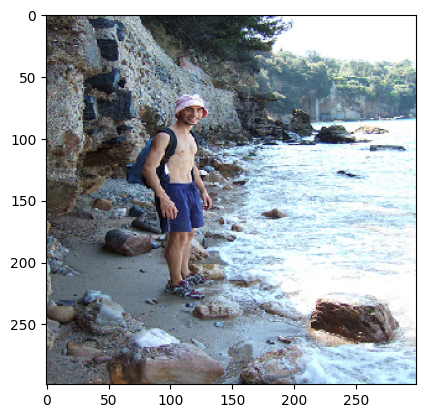

In [ ]:
#display image and caption
path = df_test["image"][idx]
print(path)
caption, image = predict(path)
plt.imshow(image)

print(caption)

In [ ]:
#ref caption are all the cpation of them image
starting = idx // 5 * 5
ending = idx + 5
ref = [text.split(" ")[1:-2] for text in df_test["caption"][starting:ending]]

candidate = caption.split(" ")[1:-2]
caption_score = sentence_bleu(ref, candidate)
print(ref)
print(caption_score)

[['a', 'man', 'stands', 'at', 'the', 'edge', 'of', 'the', 'water', 'near', 'the'], ['a', 'shirtless', 'man', 'in', 'a', 'pink', 'hat', 'is', 'standing', 'on', 'a', 'rocky'], ['a', 'shirtless', 'man', 'in', 'a', 'pink', 'hat', 'stands', 'on', 'a', 'rocky'], ['a', 'shirtless', 'man', 'with', 'a', 'backpack', 'and', 'a', 'hat', 'is', 'standing', 'on', 'a', 'rocky'], ['the', 'man', 'in', 'shorts', 'and', 'a', 'hat', 'is', 'standing', 'in', 'the', 'bay', 'beside', 'the']]
0.31170906522700675


In [ ]:
#calculate total bleu score of the model on test set
score = 0
for index, row in df_test.iterrows():
  if index % 5 != 0:
    continue
  starting = index // 5 * 5
  ending = index + 5
  caption, image = predict(row["image"])

  ref = [text.split(" ")[1:-2] for text in df_test["caption"][starting:ending]]

  candidate = caption.split(" ")[1:-2]
  score += sentence_bleu(ref, candidate)
score

1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 23ms/step


8.189528514897786

In [ ]:
#get avg bleu score
avg_score = score/((len(df_test))//5)
print('BLEU score', avg_score)

Use Ur Own Image To Predict


In [ ]:
#upload image and give path of the image
img_path = ""

In [ ]:
#get caption
#caption, image = predict(img_path)
#plt.imshow(image)
#print(caption)

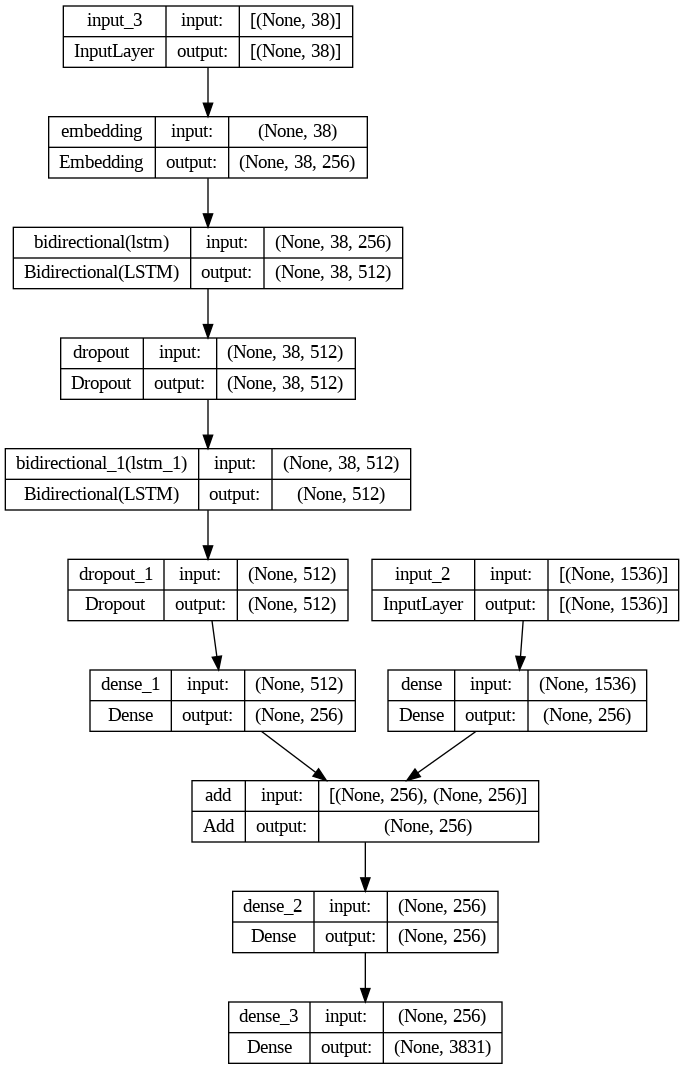

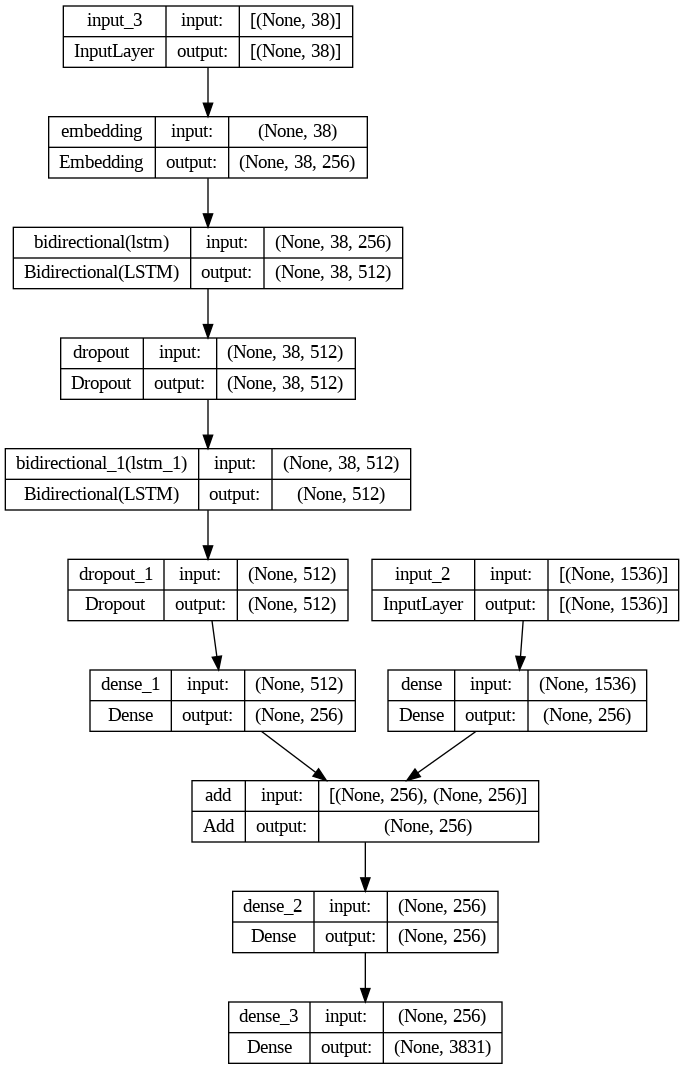

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)